I want to find the coins that have the most upward potential
- take historical data for multiple different lengths of time windows

In [1]:
# libraries
from datetime import datetime, timedelta, timezone
import ccxt
import os
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.utils import dropna
from dateutil.relativedelta import relativedelta

In [2]:
# constants
ASSETS = {"BTC/USD": "data/centroids/btc_usd_cluster_centers.json"}
symbol = list(ASSETS.keys())[0]
print(f"symbol: {symbol}")

symbol: BTC/USD


In [3]:


def fetch_kraken_ohlcv(symbol="BTC/USD", timeframe="1h",
                       lookback_amount=30, lookback_unit="days",
                       limit_per_fetch=720, pause=1.2):
    kraken = ccxt.kraken({
        'apiKey': os.getenv("KRAKEN_API_KEY"),
        'secret': os.getenv("KRAKEN_API_SECRET"),
        'enableRateLimit': True,
    })

    end_time = datetime.now(timezone.utc)

    unit_map = {
        "minutes": "minutes", "minute": "minutes", "mins": "minutes",
        "hours": "hours", "hour": "hours",
        "days": "days", "day": "days",
        "weeks": "weeks", "week": "weeks",
    }

    if lookback_unit not in unit_map:
        raise ValueError(f"Unsupported unit: {lookback_unit}")

    kwargs = {unit_map[lookback_unit]: lookback_amount}
    start_time = end_time - timedelta(**kwargs)
    since = int(start_time.timestamp() * 1000)

    all_ohlcv = []

    try:
        ohlcv = kraken.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit_per_fetch)
        all_ohlcv.extend(ohlcv)
        since = ohlcv[-1][0] + 1
    except Exception as e:
        print(f"⚠️ Error: {e}. Retrying...")

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    if len(df) < 100:
        print(f"⚠️ Only fetched {len(df)} rows for {symbol} at timeframe {timeframe}")

    return df


In [4]:

MAX_LOOKBACK_FOR_720_HOURS = {
    "1w":   720 * 168,   # 120,960 hours
    "1d":   720 * 24,    # 17,280 hours
    "4h":   720 * 4,     # 2,880 hours
    "1h":   720 * 1,     # 720 hours
    "30m":  720 * 0.5,   # 360 hours
    "15m":  720 * 0.25,  # 180 hours
    "5m":   720 * (5/60),# 60 hours
    "1m":   720 * (1/60) # 12 hours
}


tsp_key = list(MAX_LOOKBACK_FOR_720_HOURS.keys())[7]
tsp_hours = MAX_LOOKBACK_FOR_720_HOURS[tsp_key] 
print(f"tsp_key: {tsp_key}, tsp_hours: {tsp_hours}")

df = fetch_kraken_ohlcv("BTC/USD", tsp_key, lookback_amount=tsp_hours, lookback_unit="hours")
df


tsp_key: 1m, tsp_hours: 12.0


,open,high,low,close,volume
timestamp,,,,,
2025-05-06 13:16:00,93736.1,93736.1,93721.5,93736.1,3.036250
2025-05-06 13:17:00,93736.0,93736.2,93736.0,93736.2,0.021854
2025-05-06 13:18:00,93736.2,93736.3,93736.2,93736.2,0.009333
2025-05-06 13:19:00,93736.3,93740.6,93736.2,93740.6,0.071156
2025-05-06 13:20:00,93740.5,93752.4,93740.5,93752.3,0.551556
...,...,...,...,...,...
2025-05-07 01:11:00,97480.1,97480.1,97480.0,97480.1,0.030322
2025-05-07 01:12:00,97480.0,97480.1,97480.0,97480.1,2.190742
2025-05-07 01:13:00,97480.1,97480.1,97480.0,97480.1,0.171389


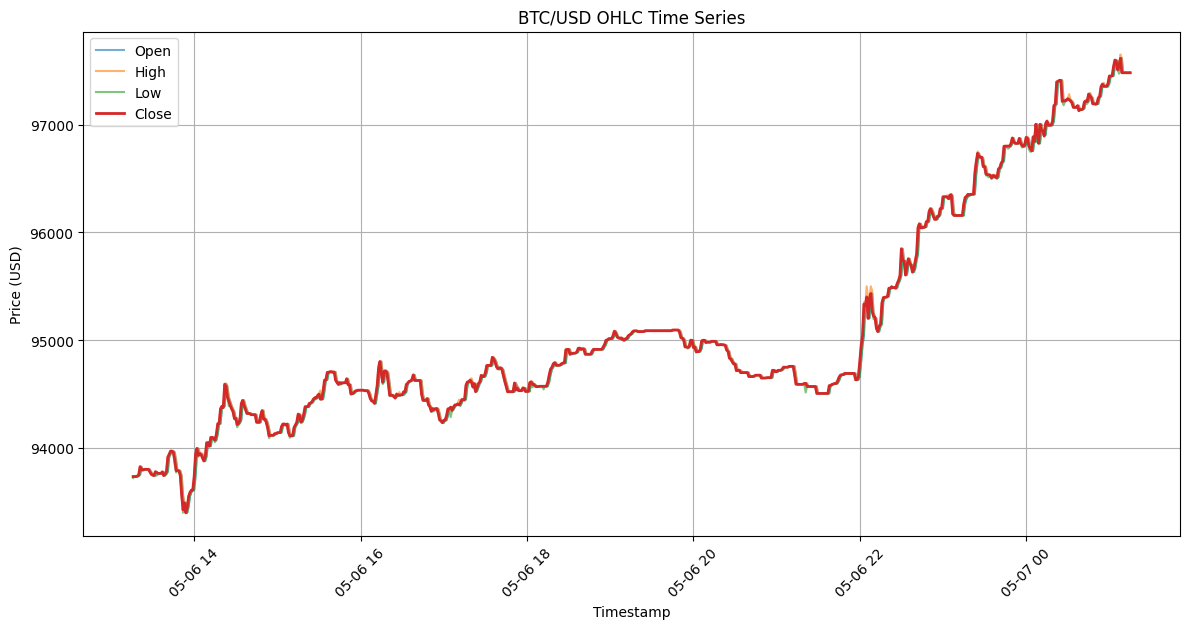

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['open'], label='Open', alpha=0.6)
plt.plot(df.index, df['high'], label='High', alpha=0.6)
plt.plot(df.index, df['low'], label='Low', alpha=0.6)
plt.plot(df.index, df['close'], label='Close', linewidth=2)

plt.title("BTC/USD OHLC Time Series")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [6]:


from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.utils import dropna

def compute_momentum_score(df):
    df = dropna(df.copy())

    # --- Momentum Indicators ---
    rsi = RSIIndicator(close=df['close'], window=14).rsi()
    macd = MACD(close=df['close'])
    macd_val = macd.macd()
    macd_signal = macd.macd_signal()
    roc = df['close'].pct_change(periods=5) * 100
    sma = df['close'].rolling(window=20).mean()

    # --- Get latest values ---
    latest_rsi = rsi.iloc[-1]
    latest_macd_diff = (macd_val - macd_signal).iloc[-1]
    latest_roc = roc.iloc[-1]
    latest_sma_ratio = df['close'].iloc[-1] / sma.iloc[-1] - 1

    # --- Normalize each component between -1 and 1 ---
    rsi_score = (latest_rsi - 50) / 50    # RSI: 0 at 50, range ~[-1, 1]
    macd_score = np.tanh(latest_macd_diff / df['close'].std())  # MACD signal diff scaled
    roc_score = np.tanh(latest_roc / 10)  # ROC scaled
    sma_score = np.tanh(latest_sma_ratio * 10)  # SMA ratio scaled

    # --- Weighted average or simple average ---
    momentum_score = np.clip((rsi_score + macd_score + roc_score + sma_score) / 4, -1, 1)

    return momentum_score



for timeframe, hours in MAX_LOOKBACK_FOR_720_HOURS.items():
    print(f"\n⏱ Timeframe: {timeframe} ({int(hours)} hours)")

    df = fetch_kraken_ohlcv("BTC/USD", timeframe, lookback_amount=hours, lookback_unit="hours")

    if df is None or df.empty or len(df) < 100:
        print(f"⚠️ Skipping {timeframe} due to insufficient data ({len(df)} rows)")
        continue

    try:
        score = compute_momentum_score(df)
        print(f"📈 Momentum Score [{timeframe}]: {score:.3f}")
    except Exception as e:
        print(f"⚠️ Error computing score for {timeframe}: {e}")



⏱ Timeframe: 1w (120960 hours)
📈 Momentum Score [1w]: 0.401

⏱ Timeframe: 1d (17280 hours)
📈 Momentum Score [1d]: 0.210

⏱ Timeframe: 4h (2880 hours)
📈 Momentum Score [4h]: 0.228

⏱ Timeframe: 1h (720 hours)
📈 Momentum Score [1h]: 0.285

⏱ Timeframe: 30m (360 hours)
📈 Momentum Score [30m]: 0.279

⏱ Timeframe: 15m (180 hours)
📈 Momentum Score [15m]: 0.257

⏱ Timeframe: 5m (60 hours)
📈 Momentum Score [5m]: 0.120

⏱ Timeframe: 1m (12 hours)
📈 Momentum Score [1m]: 0.040


# Editing to filter coins looking for positive momentum

In [13]:

import numpy as np
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.animation as animation # type: ignore
import os
from sklearn.decomposition import PCA # type: ignore
from sklearn.cluster import KMeans # type: ignore
from sklearn.metrics import mean_squared_error # type: ignore
import matplotlib.pyplot as plt # type: ignore
from scipy.stats import laplace


from dotenv import load_dotenv # type: ignore
import os
import ccxt # type: ignore
import pandas as pd # type: ignore
import time
from datetime import datetime, timedelta, timezone

import json



# Histogram setup
bin_width = 0.1
bin_range = 8
bins = np.arange(-bin_range * bin_width, (bin_range + 1) * bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
n_bins = len(bin_centers)

# Histograms (decayed over time)
hist_open = np.zeros(n_bins)
hist_high = np.zeros(n_bins)
hist_low = np.zeros(n_bins)
hist_close = np.zeros(n_bins)

# Parameters
decay_rate = 0.9  # exponential decay factor

MAX_LOOKBACK_FOR_720_HOURS = {
    "1w":   720 * 168,   # 120,960 hours
    "1d":   720 * 24,    # 17,280 hours
    "4h":   720 * 4,     # 2,880 hours
    "1h":   720 * 1,     # 720 hours
    "30m":  720 * 0.5,   # 360 hours
    "15m":  720 * 0.25,  # 180 hours
    "5m":   720 * (5/60),# 60 hours
    "1m":   720 * (1/60) # 12 hours
}




# Configurable parameters
n_centroids = 8  # Number of quantization centroids

bin_width = 0.1

bins = np.arange(-bin_range * bin_width, (bin_range + 1) * bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
n_bins = len(bin_centers)

# Histograms

histogram_vectors = []


BOUNDARY = 0.08 #   +/- 8%




def compute_momentum_score(df):
    df = dropna(df.copy())

    # --- Momentum Indicators ---
    rsi = RSIIndicator(close=df['close'], window=14).rsi()
    macd = MACD(close=df['close'])
    macd_val = macd.macd()
    macd_signal = macd.macd_signal()
    roc = df['close'].pct_change(periods=5) * 100
    sma = df['close'].rolling(window=20).mean()

    # --- Get latest values ---
    latest_rsi = rsi.iloc[-1]
    latest_macd_diff = (macd_val - macd_signal).iloc[-1]
    latest_roc = roc.iloc[-1]
    latest_sma_ratio = df['close'].iloc[-1] / sma.iloc[-1] - 1

    # --- Normalize each component between -1 and 1 ---
    rsi_score = (latest_rsi - 50) / 50    # RSI: 0 at 50, range ~[-1, 1]
    macd_score = np.tanh(latest_macd_diff / df['close'].std())  # MACD signal diff scaled
    roc_score = np.tanh(latest_roc / 10)  # ROC scaled
    sma_score = np.tanh(latest_sma_ratio * 10)  # SMA ratio scaled

    # --- Weighted average or simple average ---
    momentum_score = np.clip((rsi_score + macd_score + roc_score + sma_score) / 4, -1, 1)

    return momentum_score


# Laplace + Quantizer helpers
def fit_asymmetric_laplace_from_histogram(bin_centers, counts, loc=0):
    counts = np.asarray(counts)
    x = bin_centers - loc
    left = x < 0
    right = x >= 0
    weights_left = counts[left]
    weights_right = counts[right]
    x_left = np.abs(x[left])
    x_right = np.abs(x[right])
    b_left = np.sum(weights_left * x_left) / np.sum(weights_left) if np.sum(weights_left) > 0 else 0.05
    b_right = np.sum(weights_right * x_right) / np.sum(weights_right) if np.sum(weights_right) > 0 else 0.05
    return b_left, b_right

def lloyd_max_quantizer(x, pdf, n_centroids, max_iter=5000, tol=1e-5):
    pmf = pdf / np.sum(pdf)
    centroids = np.linspace(x.min(), x.max(), n_centroids)
    for _ in range(max_iter):
        boundaries = np.convolve(centroids, [0.5, 0.5], mode='valid')
        partitions = np.digitize(x, boundaries)
        new_centroids = []
        for k in range(n_centroids):
            mask = partitions == k
            if np.any(mask):
                weights = pmf[mask]
                new_centroids.append(np.sum(x[mask] * weights) / np.sum(weights))
            else:
                new_centroids.append(centroids[k])
        new_centroids = np.array(new_centroids)
        if np.allclose(new_centroids, centroids, atol=tol):
            break
        centroids = new_centroids
    return centroids


def get_centroids(df):
    if df.empty or not all(col in df.columns for col in ["open", "high", "low", "close"]):
        print("⚠️ DataFrame is empty or missing required columns.")
        return []

    hist_combined = np.zeros(n_bins)
    centroid_array = []

    for frame in range(len(df)):
        row = df.iloc[frame]
        base_price = row["open"]
        prices = np.array([row["open"], row["high"], row["low"], row["close"]])
        deltas = prices - base_price

        hist_combined *= decay_rate
        hist_combined += np.histogram(deltas, bins=bins)[0]

        hist = hist_combined.copy()
        b_left, b_right = fit_asymmetric_laplace_from_histogram(bin_centers, hist, loc=0)

        x = np.linspace(bin_centers[0], bin_centers[-1], 300)
        y = np.where(x < 0,
                     0.5 * np.exp(x / b_left) / b_left,
                     0.5 * np.exp(-x / b_right) / b_right)
        y *= np.sum(hist) * bin_width

        centroids = lloyd_max_quantizer(x, y, n_centroids)
        centroid_array.append(centroids)

    if len(centroid_array) == 0:
        print("⚠️ No centroids computed.")
    return centroid_array


    

def cluster_centroids(centroid_series, n_clusters=8, random_state=42):
    if len(centroid_series) == 0:
        raise ValueError("No centroid vectors to cluster — check data pipeline.")

    centroid_matrix = np.stack(centroid_series.to_numpy())

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(centroid_matrix)

    def quantize_centroids(new_centroids):
        new_centroids = np.atleast_2d(new_centroids)
        return kmeans.predict(new_centroids)

    return labels, kmeans, quantize_centroids





def fetch_kraken_ohlcv(symbol="BTC/USD", timeframe="1h",
                       lookback_amount=30, lookback_unit="days",
                       limit_per_fetch=720, pause=1.2):
    kraken = ccxt.kraken({
        'apiKey': os.getenv("KRAKEN_API_KEY"),
        'secret': os.getenv("KRAKEN_API_SECRET"),
        'enableRateLimit': True,
    })

    end_time = datetime.now(timezone.utc)

    unit_map = {
        "minutes": "minutes", "minute": "minutes", "mins": "minutes",
        "hours": "hours", "hour": "hours",
        "days": "days", "day": "days",
        "weeks": "weeks", "week": "weeks",
    }

    if lookback_unit not in unit_map:
        raise ValueError(f"Unsupported unit: {lookback_unit}")

    kwargs = {unit_map[lookback_unit]: lookback_amount}
    start_time = end_time - timedelta(**kwargs)
    since = int(start_time.timestamp() * 1000)

    all_ohlcv = []

    try:
        ohlcv = kraken.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit_per_fetch)
        all_ohlcv.extend(ohlcv)
        since = ohlcv[-1][0] + 1
    except Exception as e:
        print(f"⚠️ Error: {e}. Retrying...")

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    if len(df) < 100:
        print(f"⚠️ Only fetched {len(df)} rows for {symbol} at timeframe {timeframe}")

    return df



def find_good_clusters(df, buy_fee=0.025, boundary=0.08):
    df["mid_price"] = df[["open", "high", "low", "close"]].median(axis=1)

    cluster_success_counts = {}
    cluster_total_counts = {}

    for i in range(len(df) - 1):
        cluster = df.iloc[i]["laplace_cluster"]
        midpoint = df.iloc[i]["mid_price"]

        entry_price = midpoint * (1 + buy_fee)
        exit_target = entry_price * (1 + boundary)
        stop_loss_target = entry_price * (1 - boundary)

        future_prices = df.iloc[i+1:]["mid_price"].values

        hit_upper = np.argmax(future_prices >= exit_target) if np.any(future_prices >= exit_target) else None
        hit_lower = np.argmax(future_prices <= stop_loss_target) if np.any(future_prices <= stop_loss_target) else None

        success = False
        if hit_upper is not None and hit_lower is not None:
            success = hit_upper < hit_lower
        elif hit_upper is not None:
            success = True
        else:
            success = False

        cluster_total_counts[cluster] = cluster_total_counts.get(cluster, 0) + 1
        if success:
            cluster_success_counts[cluster] = cluster_success_counts.get(cluster, 0) + 1

    success_ratios = {}
    for cluster in cluster_total_counts:
        total = cluster_total_counts[cluster]
        success = cluster_success_counts.get(cluster, 0)
        ratio = success / (total + 2)  # Wilson smoothing
        success_ratios[cluster] = ratio

    summary_df = pd.DataFrame({
        "cluster": list(success_ratios.keys()),
        "success_ratio": list(success_ratios.values()),
        "successes": [cluster_success_counts.get(c, 0) for c in success_ratios],
        "total": [cluster_total_counts[c] for c in success_ratios]
    }).sort_values("success_ratio", ascending=False)

    print(summary_df)
    
    return df, summary_df


def search_best_boundary(df, cluster_fn, min_b=0.01, max_b=0.20, step=0.01, fee=0.025):
    boundaries = np.arange(min_b, max_b + step, step)
    best_score = -1
    best_boundary = None

    for b in boundaries:
        try:
            df_clusters, df_summary = cluster_fn(df, buy_fee=fee, boundary=b)

            current_bin = int(df_clusters["laplace_cluster"].iloc[-1])
            score = float(df_summary.loc[df_summary["cluster"] == current_bin, "success_ratio"].values[0])

            print(f"[B={b:.3f}] Score = {score:.4f}")

            if score > best_score:
                best_score = score
                best_boundary = b

        except Exception as e:
            print(f"⚠️ BOUNDARY={b:.3f} failed: {e}")
            continue

    print(f"\n🏆 Best BOUNDARY: {best_boundary:.3f} with score: {best_score:.4f}")
    return best_boundary, best_score




def ranked(assets):
    load_dotenv()
    cluster_models = {}
    coin_details = {}

    for symbol, json_file in assets.items():
        print(f"\n🚀 Processing {symbol}...")

        # Aggregate boundary performance across all timeframes
        boundary_scores = {}
        current_price = None

        for timeframe, hours in MAX_LOOKBACK_FOR_720_HOURS.items():
            try:
                df = fetch_kraken_ohlcv(symbol, timeframe, lookback_amount=int(hours), lookback_unit="hours")
                if df is None or df.empty or len(df) < 100:
                    print(f"⚠️ Skipping {symbol} [{timeframe}]: insufficient data.")
                    continue

                print(f"✅ [{symbol}] Positive momentum on {timeframe}")

                # Preprocess
                df = df[['open', 'high', 'low', 'close']].dropna()
                centroids = get_centroids(df)
                if not centroids:
                    print(f"⚠️ Skipping {symbol} [{timeframe}]: centroid extraction failed.")
                    continue

                df["laplace_centroids"] = centroids
                labels, kmeans_model, quantize_centroids = cluster_centroids(df["laplace_centroids"], n_clusters=8)
                df["laplace_cluster"] = labels

                # Try multiple boundaries and accumulate scores
                for b in np.arange(0.01, 0.16, 0.01):
                    try:
                        df_clusters, df_summary = find_good_clusters(df, buy_fee=0.025, boundary=b)
                        current_bin = int(df_clusters["laplace_cluster"].iloc[-1])
                        score = float(df_summary.loc[df_summary["cluster"] == current_bin, "success_ratio"].values[0])
                        boundary_scores[b] = boundary_scores.get(b, 0) + score
                        if current_price is None:
                            current_price = float(df_clusters["mid_price"].iloc[-1])
                    except:
                        continue

            except Exception as e:
                print(f"⚠️ Error processing {symbol} [{timeframe}]: {e}")
                continue

        if not boundary_scores:
            print(f"🚫 No usable boundaries for {symbol}")
            continue

        # Pick boundary with highest total score across timeframes
        best_boundary = max(boundary_scores.items(), key=lambda x: x[1])[0]

        print(f"🏁 Best boundary fo {symbol}: {best_boundary:.2%} with total score: {boundary_scores[best_boundary]:.4f}")

        # Re-evaluate current bin score at best boundary
        try:
            df = fetch_kraken_ohlcv(symbol, "1h", lookback_amount=720, lookback_unit="hours")
            df = df[['open', 'high', 'low', 'close']].dropna()
            centroids = get_centroids(df)
            df["laplace_centroids"] = centroids
            labels, kmeans_model, quantize_centroids = cluster_centroids(df["laplace_centroids"], n_clusters=8)
            df["laplace_cluster"] = labels
            df_clusters, df_summary = find_good_clusters(df, buy_fee=0.025, boundary=best_boundary)
            current_bin = int(df_clusters["laplace_cluster"].iloc[-1])
            final_score = float(df_summary.loc[df_summary["cluster"] == current_bin, "success_ratio"].values[0])
        except Exception as e:
            print(f"⚠️ Final scoring failed for {symbol}: {e}")
            continue

        coin_details[symbol] = {
            "score": round(final_score, 4),
            "price": round(current_price, 8),
            "sell_price": round(current_price * (1 - best_boundary), 8),
            "drop_order_price": round(current_price * (1 + best_boundary), 8),
            "optimized_boundary": round(best_boundary, 4)
        }

    # Rank and save
    sorted_items = sorted(coin_details.items(), key=lambda x: -x[1]["score"])
    sorted_dict = {symbol: details for symbol, details in sorted_items}

    with open("data/ranked_coins.json", "w") as f:
        json.dump(sorted_dict, f, indent=2)

    print("✅ Saved ranked coin scores to ranked_coins.json")





if __name__ == "__main__":
    assets = {
        "APE/USD": "data/centroids/btc_usd_cluster_centers.json"
        }

    load_dotenv()
    ranked(assets)


🚀 Processing APE/USD...
✅ [APE/USD] Positive momentum on 1w
   cluster  success_ratio  successes  total
7        1       0.692308          9     11
5        5       0.428571          9     19
3        4       0.372093         16     41
6        7       0.350000          7     18
0        3       0.200000          2      8
1        2       0.200000          6     28
4        6       0.125000          3     22
2        0       0.055556          1     16
   cluster  success_ratio  successes  total
7        1       0.692308          9     11
5        5       0.428571          9     19
3        4       0.348837         15     41
6        7       0.300000          6     18
0        3       0.200000          2      8
1        2       0.166667          5     28
4        6       0.125000          3     22
2        0       0.055556          1     16
   cluster  success_ratio  successes  total
7        1       0.615385          8     11
5        5       0.428571          9     19
3        4     

In [ ]:


assets = {
    "BTC/USD": "data/centroids/btc_usd_cluster_centers.json",
    "ETH/USD": "data/centroids/eth_usd_cluster_centers.json",
    "SOL/USD": "data/centroids/sol_usd_cluster_centers.json",
    "XRP/USD": "data/centroids/xrp_usd_cluster_centers.json",
    "TON/USD": "data/centroids/ton_usd_cluster_centers.json",
    "DOGE/USD": "data/centroids/doge_usd_cluster_centers.json",
    "ADA/USD": "data/centroids/ada_usd_cluster_centers.json",
    "DOT/USD": "data/centroids/dot_usd_cluster_centers.json",
    "AVAX/USD": "data/centroids/avax_usd_cluster_centers.json",
    "LINK/USD": "data/centroids/link_usd_cluster_centers.json",
    "MATIC/USD": "data/centroids/matic_usd_cluster_centers.json",
    "SHIB/USD": "data/centroids/shib_usd_cluster_centers.json",
    "ATOM/USD": "data/centroids/atom_usd_cluster_centers.json",
    "LTC/USD": "data/centroids/ltc_usd_cluster_centers.json",
    "TRX/USD": "data/centroids/trx_usd_cluster_centers.json",
    "XLM/USD": "data/centroids/xlm_usd_cluster_centers.json",
    "FIL/USD": "data/centroids/fil_usd_cluster_centers.json",
    "UNI/USD": "data/centroids/uni_usd_cluster_centers.json",
    "ALGO/USD": "data/centroids/algo_usd_cluster_centers.json",
    "EGLD/USD": "data/centroids/egld_usd_cluster_centers.json",
    "AAVE/USD": "data/centroids/aave_usd_cluster_centers.json",
    "NEAR/USD": "data/centroids/near_usd_cluster_centers.json",
    "XTZ/USD": "data/centroids/xtz_usd_cluster_centers.json",
    "CRV/USD": "data/centroids/crv_usd_cluster_centers.json",
    "RUNE/USD": "data/centroids/rune_usd_cluster_centers.json",
    "INJ/USD": "data/centroids/inj_usd_cluster_centers.json",
    "LDO/USD": "data/centroids/ldo_usd_cluster_centers.json",
    "SUI/USD": "data/centroids/sui_usd_cluster_centers.json",
    "OP/USD": "data/centroids/op_usd_cluster_centers.json",
    "STX/USD": "data/centroids/stx_usd_cluster_centers.json",
    "GRT/USD": "data/centroids/grt_usd_cluster_centers.json",
    "FLOW/USD": "data/centroids/flow_usd_cluster_centers.json",
    "ENS/USD": "data/centroids/ens_usd_cluster_centers.json",
    "IMX/USD": "data/centroids/imx_usd_cluster_centers.json",
    "SNX/USD": "data/centroids/snx_usd_cluster_centers.json",
    "KAVA/USD": "data/centroids/kava_usd_cluster_centers.json",
    "BCH/USD": "data/centroids/bch_usd_cluster_centers.json",
    "SAND/USD": "data/centroids/sand_usd_cluster_centers.json",
    "CHZ/USD": "data/centroids/chz_usd_cluster_centers.json",
    "APE/USD": "data/centroids/ape_usd_cluster_centers.json",
    "AXS/USD": "data/centroids/axs_usd_cluster_centers.json",
    "DYDX/USD": "data/centroids/dydx_usd_cluster_centers.json",
    "COMP/USD": "data/centroids/comp_usd_cluster_centers.json",
}




🚀 Checking momentum for BTC/USD...
📊 Total momentum score for BTC/USD: 1.744
✅ Positive momentum detected. Proceeding with BTC/USD...
   cluster  success_ratio  successes  total
2        2       0.819048         86    103
6        4       0.533333          8     13
1        0       0.529018        237    446
3        6       0.516129         32     60
0        1       0.166667          6     34
4        7       0.062500          2     30
5        3       0.035714          1     26
7        5       0.000000          0      8

🚀 Checking momentum for ETH/USD...
📊 Total momentum score for ETH/USD: 1.057
✅ Positive momentum detected. Proceeding with ETH/USD...
   cluster  success_ratio  successes  total
2        6       0.660606        109    163
7        5       0.593750         19     30
4        7       0.543210         44     79
6        4       0.533333         16     28
1        2       0.399103         89    221
5        0       0.326531         16     47
3        3       0.320312 